### Initialization of pandas dataframe

In [307]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

original_df = pd.read_csv("raw_data.csv")
original_df = original_df.drop(columns=['index'])

### Dropping Palawan rows since suspicious yung data nila

In [308]:
df = original_df[original_df['crop'] != 'PALAWAN, YELLOW, 1 KG']
df = df.query("month != 'Annual'")

In [309]:
df['category'].unique()

array(['CEREALS', 'ROOTCROPS', 'BEANS & LEGUMES', 'CONDIMENTS',
       'FRUIT VEGETABLES', 'LEAFY VEGETABLES', 'FRUITS',
       'COMMERCIAL CROPS', 'LIVESTOCK', 'POULTRY', 'FISH'], dtype=object)

### Convert Month and Year to numeric value

In [310]:
# Convert month to numeric
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['month_numeric'] = df['month'].map(month_dict)

# Combine month and year to a numeric column
df['month_year_numeric'] = df['year'] * 100 + df['month_numeric']

In [311]:
df

,crop,month,year,price,category,month_numeric,month_year_numeric
0,"RICE, WELL-MILLED, 1 KG",Jan,2020,43.02,CEREALS,1,202001
1,"RICE, WELL-MILLED, 1 KG",Feb,2020,42.86,CEREALS,2,202002
2,"RICE, WELL-MILLED, 1 KG",Mar,2020,42.66,CEREALS,3,202003
3,"RICE, WELL-MILLED, 1 KG",Apr,2020,43.61,CEREALS,4,202004
4,"RICE, WELL-MILLED, 1 KG",May,2020,43.88,CEREALS,5,202005
...,...,...,...,...,...,...,...
10446,"FRESH SEAWEEDS, LATO, 1 KG",Aug,2023,151.58,FISH,8,202308
10447,"FRESH SEAWEEDS, LATO, 1 KG",Sep,2023,151.16,FISH,9,202309
10448,"FRESH SEAWEEDS, LATO, 1 KG",Oct,2023,150.75,FISH,10,202310
10449,"FRESH SEAWEEDS, LATO, 1 KG",Nov,2023,151.58,FISH,11,202311


### Prepare Crop Combinations

In [312]:
from itertools import combinations
import numpy as np

# unique_categories = df['category'].unique()
# print(unique_categories)

# unique_crops = df.query("category == 'FISH'")
# unique_crops = unique_crops['crop'].unique()
# unique_crops = np.append("RICE, WELL-MILLED, 1 KG", unique_crops)

# print(unique_crops)
#unique_crops = df['crop'].unique()

unique_crops = ["RICE, WELL-MILLED, 1 KG",
                "WHOLE CORN GRAIN, YELLOW, 1 KG",
                "POTATO, 1 KG",
                "RAW PEANUT, SHELLED, 1 KG",
                "GINGER, LOOSE, 1 KG",
                "CHAYOTE, 1 KG",
                "CAMOTE TOPS, 1 KG",
                "FRESH FRUIT, BANANA, SABA, MEDIUM, 1 KG",
                "YOUNG COCONUT, MEDIUM, 1 PC",
                "FRESH BEEF, PURE MEAT, 1 KG",
                "FRESH EGG, CHICKEN, NATIVE, MEDIUM, 1 PC",
                "FRESH CHICKEN, NATIVE, 1 KG",
                "FRESH SHRIMP, SUAJE (DARK GREEN), MEDIUM, 1 KG",
                "FRESH FISH, TILAPIA, MEDIUM, 1 KG",
                "FRESH SHRIMP, ACETES, MEDIUM, 1 KG"
            ]

crop_pairs = list(combinations(unique_crops, 2))
correlation_results = {}

### Compute Pearson correlation between the prices of the two crops

In [313]:
# Loop through each crop pair
for crop1, crop2 in crop_pairs:
    # Select data for the first crop
    
    # ###########################RICE ONLY FOR CROP 1################################
    # if crop1 != 'RICE, WELL-MILLED, 1 KG':
    #     continue
    # ###########################RICE ONLY FOR CROP 1################################
    
    crop1_data = df[df['crop'] == crop1]
    
    # Select data for the second crop
    crop2_data = df[df['crop'] == crop2]
    
    # if crop1_data['category'].unique() == crop2_data['category'].unique():
    #     continue
    
    # Merge data for the two crops based on 'year' and 'month'
    merged_data = pd.merge(crop1_data, crop2_data, on=['year', 'month'])
    
    # Compute Pearson correlation between the prices of the two crops
    correlation = merged_data['price_x'].corr(merged_data['price_y'])
    
    # Store the correlation coefficient in the dictionary
    correlation_results[(crop1, crop2)] = correlation

# Convert dictionary to DataFrame for easier analysis
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson Correlation'])

### Create a correlation matrix

In [ ]:
correlation_matrix = pd.DataFrame(index=unique_crops, columns=unique_crops)

# Fill in the correlation matrix
for (crop1, crop2), correlation in correlation_results.items():
    correlation_matrix.at[crop1, crop2] = correlation
    correlation_matrix.at[crop2, crop1] = correlation

# Ensure diagonal values are 1 (self-correlation)
for crop in unique_crops:
    correlation_matrix.at[crop, crop] = 1

# Optionally, visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='vlag', linewidths=0.5, fmt=".3f")
plt.title('Crop Price Correlation Matrix')
plt.show()

### Print correlations

In [ ]:
sorted_correlation_df = correlation_df.sort_values(by='Pearson Correlation', ascending=False)

# Display the top 10 correlations
print("Top correlations:")
sorted_correlation_df.head(20)

### Kruskal Willis Test for seasonality (function)

In [314]:
from scipy.stats import kruskal
import calendar

def seasonality_analysis(df, unique_crops):
    results = []
    unique_crops = df['crop'].unique()

    for crop in unique_crops:
        crop_data = df[df['crop'] == crop]

        # Monthly mean and standard deviation
        monthly_stats = crop_data.groupby('month')['price'].agg(['mean', 'std']).reset_index()
        
        # Sort months from January to December
        months_ordered = [month for month in calendar.month_abbr if month in monthly_stats['month'].unique()]
        monthly_stats = monthly_stats.set_index('month').loc[months_ordered].reset_index()

        # Overall mean and standard deviation
        overall_mean = crop_data['price'].mean()
        overall_std = crop_data['price'].std()

        # Difference between each month's average and overall average
        monthly_diff_from_overall_mean = monthly_stats['mean'] - overall_mean
        
        # Number of standard deviations each month's average differs from overall average
        sigma_diff_from_overall_mean = monthly_diff_from_overall_mean / overall_std
        
        # Kruskal-Wallis test
        grouped_data = [crop_data[crop_data['month'] == month]['price'].values for month in months_ordered]
        h_stat, p_value = kruskal(*grouped_data)
        seasonal = 'Yes' if p_value < 0.05 else 'No'
        
        # Store results
        results.append({
            'crop': crop,
            'seasonal?': seasonal,
            'mean_per_month': monthly_stats['mean'].tolist(),
            'months': monthly_stats['month'].tolist(),
            'sigma_diff_from_overall_mean': sigma_diff_from_overall_mean.tolist()
        })
    
    return results

seasonality_results = seasonality_analysis(df, unique_crops)
seasonality_results


[{'crop': 'RICE, WELL-MILLED, 1 KG',
  'seasonal?': 'No',
  'mean_per_month': [43.227500000000006,
   43.25,
   43.2925,
   43.645,
   43.815,
   43.965,
   44.1175,
   44.7575,
   45.9225,
   45.385000000000005,
   45.5975,
   46.0725],
  'months': ['Jan',
   'Feb',
   'Mar',
   'Apr',
   'May',
   'Jun',
   'Jul',
   'Aug',
   'Sep',
   'Oct',
   'Nov',
   'Dec'],
  'sigma_diff_from_overall_mean': [-0.46434867428355536,
   -0.45559196801105484,
   -0.4390515228296616,
   -0.30186312456044595,
   -0.2357013438348701,
   -0.17732330201818144,
   -0.11797229283788499,
   0.13110735224664408,
   0.5845101436895752,
   0.3753221605131176,
   0.45802438642008675,
   0.642888185506261]},
 {'crop': 'RICE, REGULAR-MILLED, 1 KG',
  'seasonal?': 'No',
  'mean_per_month': [38.72,
   38.6775,
   38.6975,
   39.13,
   39.35,
   39.504999999999995,
   39.6975,
   40.235,
   41.2575,
   40.56,
   40.795,
   41.22],
  'months': ['Jan',
   'Feb',
   'Mar',
   'Apr',
   'May',
   'Jun',
   'Jul',
   'A

### Plot into graph

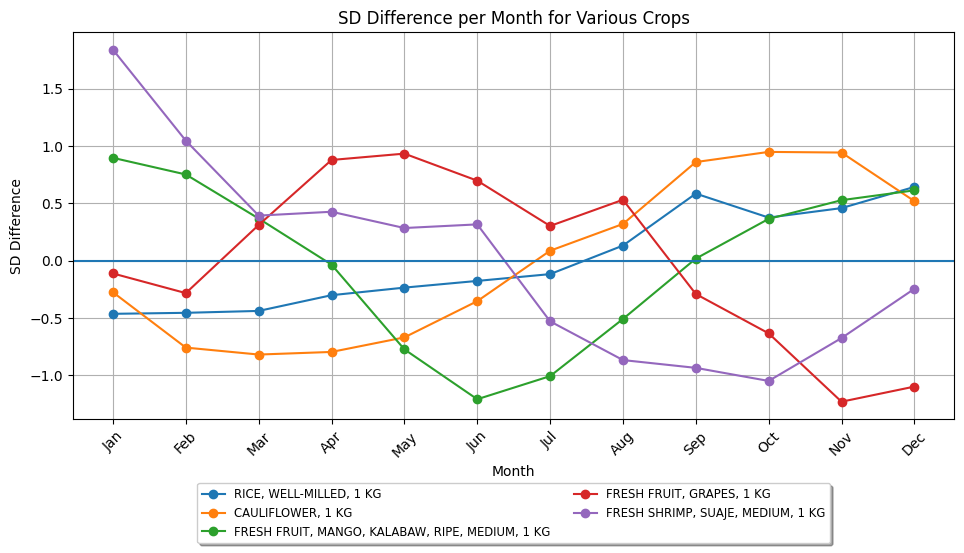

In [259]:
def plot_sd_difference(seasonality_results):
    plt.figure(figsize=(10, 6))  # Adjust the figure size to make it more compact

    for result in seasonality_results:
        crops_to_plot = [
            'RICE, WELL-MILLED, 1 KG',
            'CAULIFLOWER, 1 KG',
            'FRESH FRUIT, MANGO, KALABAW, RIPE, MEDIUM, 1 KG',
            'FRESH FRUIT, GRAPES, 1 KG',
            'FRESH SHRIMP, SUAJE, MEDIUM, 1 KG'
        ]
        if result['crop'] not in crops_to_plot:
            continue
        crop = result['crop']
        sd_diff = result['sigma_diff_from_overall_mean']
        months = result['months']
        
        plt.plot(months, sd_diff, marker='o', linestyle='-', label=crop)

    plt.title('SD Difference per Month for Various Crops')
    plt.xlabel('Month')
    plt.ylabel('SD Difference')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize='small')
    plt.tight_layout(pad=2)  # Adjust the padding to make the layout more compact
    plt.axhline()
    plt.show()
            
plot_sd_difference(seasonality_results)


### Sept 2023 Shenanigans

In [320]:
before_july_2023 = df[df['month_year_numeric'] == 202308]
after_july_2023 = df[df['month_year_numeric'] == 202309]

avg_price_before = before_july_2023.groupby('crop')['price'].mean()
avg_price_after = after_july_2023.groupby('crop')['price'].mean()

# Merge average prices before and after July 2023
avg_prices = pd.merge(avg_price_before, avg_price_after, on='crop', suffixes=('_before', '_after'))

# Calculate the percentage change in average price
avg_prices['price_change_percentage'] = ((avg_prices['price_after'] - avg_prices['price_before']) / avg_prices['price_before']) * 100

# Filter crops with a drastic increase in average price after July 2023 (e.g., more than 50% increase)
drastic_increase_crops = avg_prices[(avg_prices['price_change_percentage'] > 10)]

print(drastic_increase_crops[['price_before', 'price_after', 'price_change_percentage']])


                                                 price_before  price_after  \
crop                                                                         
BAGUIO BEANS, 1 KG                                     123.88       143.09   
CAULIFLOWER, 1 KG                                      209.44       240.74   
CHAYOTE, 1 KG                                           47.24        59.94   
FRESH FRUIT, MANGO, CEBU, RIPE, MEDIUM, 1 KG           117.38       129.56   
FRESH FRUIT, MANGO, KALABAW, RIPE, MEDIUM, 1 KG        146.62       163.07   
FRESH FRUIT, MANGO, NATIVE, MEDIUM, 1 KG                92.43       113.27   
FRESH FRUIT, MANGO, PIKO, RIPE, MEDIUM, 1 KG           123.96       144.69   
FRESH FRUIT, MANGO, RIPE, MEDIUM, 1 KG                 135.72       155.48   
POTATO, IRISH (WHITE), 1 KG                            141.25       156.75   
RICE, WELL-MILLED, 1 KG                                 47.65        52.69   
TOMATO, 1 KG                                            99.02   